In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tushare as ts
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset
from tqdm import tqdm


In [14]:
class Config():
    data_path = '../data.csv'
    timestep = 20  # 时间步长，就是利用多少时间窗口
    batch_size = 32  # 批次大小
    feature_size = 1  # 每个步长对应的特征数量，这里只使用1维，每天的风速
    hidden_size = 256  # 隐层大小
    out_channels = 50 # CNN输出通道
    num_heads = 1 # 注意力机制头的数量
    output_size = 1  # 由于是单输出任务，最终输出层大小为1，预测未来1天风速
    num_layers = 2  # lstm的层数
    epochs = 10 # 迭代轮数
    best_loss = 0 # 记录损失
    learning_rate = 0.0003 # 学习率
    model_name = 'cnn_lstm_attention' # 模型名称
    save_path = './{}.pth'.format(model_name) # 最优模型保存路径

config = Config()



In [28]:
# 1.加载时间序列数据
df = pd.read_csv(config.data_path, index_col = 0)
print(df.shape)
df.head()

(26280, 7)


,load,year,month,hour,day,lowtmep,hightemp
date,,,,,,,
2016/11/25 0:00,193.987,0.0,0.909091,0.000000,0.666667,0.302326,0.243902
2016/11/25 1:00,187.120,0.0,0.909091,0.043478,0.666667,0.302326,0.243902
2016/11/25 2:00,189.514,0.0,0.909091,0.086957,0.666667,0.302326,0.243902
2016/11/25 3:00,190.690,0.0,0.909091,0.130435,0.666667,0.302326,0.243902
2016/11/25 4:00,206.349,0.0,0.909091,0.173913,0.666667,0.302326,0.243902


In [17]:

# 2.将数据进行标准化
scaler = MinMaxScaler()
scaler_model = MinMaxScaler()
data = scaler_model.fit_transform(np.array(df))
scaler.fit_transform(np.array(df['load']).reshape(-1, 1))

# 形成训练数据，例如12345789 12-3456789
def split_data(data, timestep, feature_size):
    dataX = []  # 保存X
    dataY = []  # 保存Y

    # 将整个窗口的数据保存到X中，将未来一天保存到Y中
    for index in range(len(data) - timestep):
        dataX.append(data[index: index + timestep][:, 0])
        dataY.append(data[index + timestep][0])

    dataX = np.array(dataX)
    dataY = np.array(dataY)

    # 获取训练集大小
    train_size = int(np.round(0.8 * dataX.shape[0]))

    # 划分训练集、测试集
    x_train = dataX[: train_size, :].reshape(-1, timestep, feature_size)
    y_train = dataY[: train_size].reshape(-1, 1)

    x_test = dataX[train_size:, :].reshape(-1, timestep, feature_size)
    y_test = dataY[train_size:].reshape(-1, 1)

    return [x_train, y_train, x_test, y_test]



In [18]:
# 3.获取训练数据   x_train: 170000,30,1   y_train:170000,7,1
x_train, y_train, x_test, y_test = split_data(data, config.timestep, config.feature_size)


In [19]:
# 4.将数据转为tensor
x_train_tensor = torch.from_numpy(x_train).to(torch.float32)
y_train_tensor = torch.from_numpy(y_train).to(torch.float32)
x_test_tensor = torch.from_numpy(x_test).to(torch.float32)
y_test_tensor = torch.from_numpy(y_test).to(torch.float32)



In [20]:
# 5.形成训练数据集
train_data = TensorDataset(x_train_tensor, y_train_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)



In [21]:
# 6.将数据加载成迭代器
train_loader = torch.utils.data.DataLoader(train_data,
                                           config.batch_size,
                                           False)

test_loader = torch.utils.data.DataLoader(test_data,
                                          config.batch_size,
                                          False)



In [22]:
# 7.定义CNN + LSTM + Attention网络
class CNN_LSTM_Attention(nn.Module):
    def __init__(self, feature_size, timestep, hidden_size, num_layers, out_channels, num_heads, output_size):
        super(CNN_LSTM_Attention, self).__init__()
        self.hidden_size = hidden_size  # 隐层大小
        self.num_layers = num_layers  # lstm层数
        
        # 卷积层
        self.conv1d = nn.Conv1d(in_channels=feature_size, out_channels=out_channels, kernel_size=3, padding=1)
        
        # LSTM层
        # feature_size为特征维度，就是每个时间点对应的特征数量，这里为 1
        self.lstm = nn.LSTM(out_channels, hidden_size, num_layers, batch_first=True)
        
        # 注意力层
        self.attention = nn.MultiheadAttention(embed_dim=self.hidden_size, num_heads=num_heads, batch_first=True, dropout=0.8)
        
        # 输出层
        self.fc1 = nn.Linear(timestep * hidden_size, 256)
        self.fc2 = nn.Linear(256, output_size)
        
        # 激活函数
        self.relu = nn.ReLU()

    def forward(self, x, hidden=None):
        x = x.transpose(1, 2) # batch_size, feature_size, timestep[32, 1, 20]
        
        # 卷积运算
        output = self.conv1d(x)
        
        batch_size = x.shape[0] # 获取批次大小
        
        # 初始化隐层状态
        if hidden is None:
            h_0 = x.data.new(self.num_layers, batch_size, self.hidden_size).fill_(0).float()
            c_0 = x.data.new(self.num_layers, batch_size, self.hidden_size).fill_(0).float()
        else:
            h_0, c_0 = hidden
        
        output = output.transpose(1, 2) # batch_size, feature_size, timestep[32, 1, 20]
        
        # LSTM运算
        output, (h_0, c_0) = self.lstm(output, (h_0, c_0)) # batch_size, timestep, hidden_size
        
        # 注意力计算
        attention_output, attn_output_weights = self.attention(output, output, output)
        
        # 展开
        output = output.flatten(start_dim=1)
        
        # 全连接层
        output = self.fc1(output)
        output = self.relu(output)
        
        output = self.fc2(output)
        
        return output

model = CNN_LSTM_Attention(config.feature_size, config.timestep, config.hidden_size, config.num_layers, config.out_channels, config.num_heads, config.output_size)  # 定义CNN + LSTM + Attention网络
loss_function = nn.MSELoss()  # 定义损失函数
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)  # 定义优化器



In [23]:
# 8.模型训练
for epoch in range(config.epochs):
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader)  # 形成进度条
    for data in train_bar:
        x_train, y_train = data  # 解包迭代器中的X和Y
        optimizer.zero_grad()
        y_train_pred = model(x_train)
        loss = loss_function(y_train_pred, y_train.reshape(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 config.epochs,
                                                                 loss)

    # 模型验证
    model.eval()
    test_loss = 0
    with torch.no_grad():
        test_bar = tqdm(test_loader)
        for data in test_bar:
            x_test, y_test = data
            y_test_pred = model(x_test)
            test_loss = loss_function(y_test_pred, y_test.reshape(-1, 1))

    if test_loss < config.best_loss:
        config.best_loss = test_loss
        torch.save(model.state_dict(), save_path)

print('Finished Training')



100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [00:06<00:00, 25.08it/s]

Finished Training


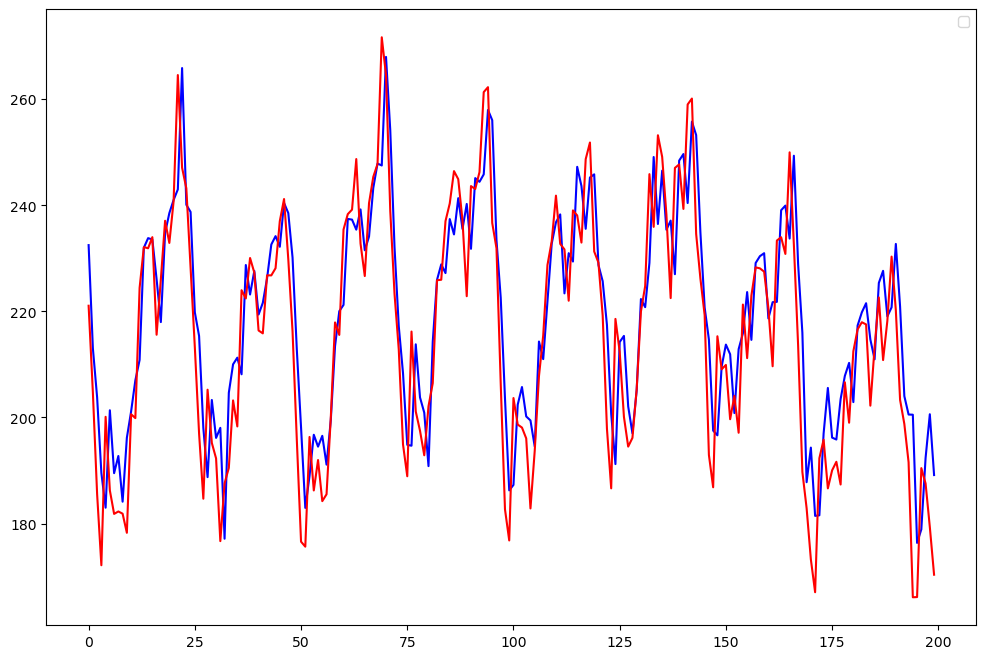

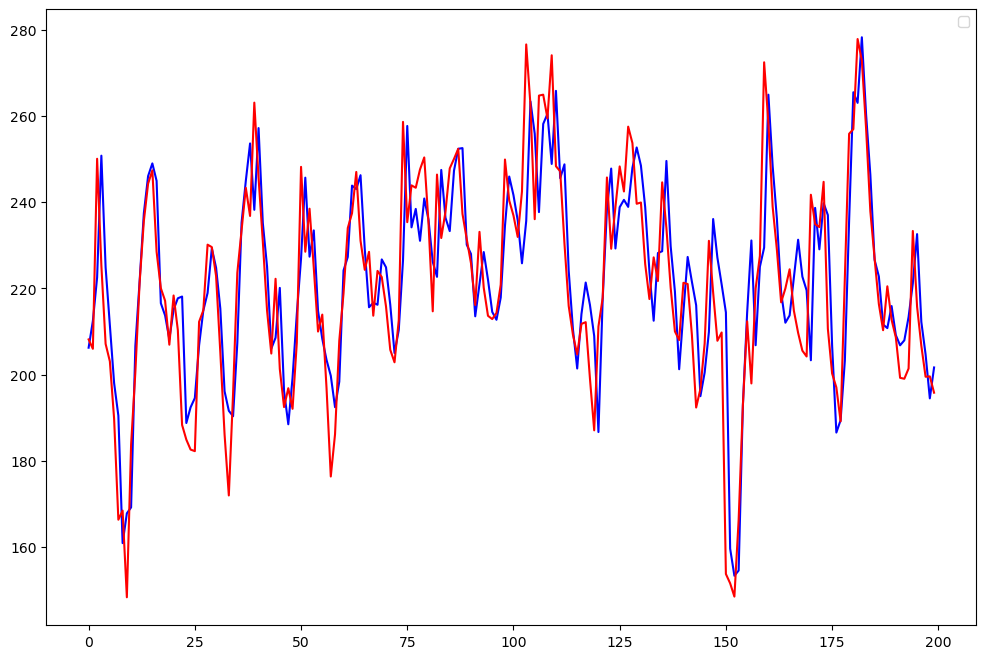

In [24]:
# 9.绘制结果
plot_size = 200
plt.figure(figsize=(12, 8))
plt.plot(scaler.inverse_transform((model(x_train_tensor).detach().numpy()[: plot_size]).reshape(-1, 1)), "b")
plt.plot(scaler.inverse_transform(y_train_tensor.detach().numpy().reshape(-1, 1)[: plot_size]), "r")
plt.legend()
plt.show()

y_test_pred = model(x_test_tensor)
plt.figure(figsize=(12, 8))
plt.plot(scaler.inverse_transform(y_test_pred.detach().numpy()[: plot_size]), "b")
plt.plot(scaler.inverse_transform(y_test_tensor.detach().numpy().reshape(-1, 1)[: plot_size]), "r")
plt.legend()
plt.show()